In [2]:
import os
from typing import List, Tuple

import librosa
import librosa.display
from librosa.util import peak_pick
from librosa.core import load
from librosa.onset import onset_detect, onset_backtrack
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from beat2d import settings, slicing

In [3]:
def read_sample(path: str):
    sample: np.ndarray
    sample, _ = load(path, settings.SAMPLE_RATE) # Load returns sample and sample rate
    return sample

In [4]:
def read_play_sample(path: str):
    sample = read_sample(path)
    sd.play(sample, settings.SAMPLE_RATE)
    sd.wait()

In [6]:
s = read_sample("../data/recordings/kicks.wav")

In [7]:
ipd.Audio(s, rate=settings.SAMPLE_RATE)

In [8]:
# We can convert the number of samples in the array to seconds by dividing by sample rate
s.shape[0] / settings.SAMPLE_RATE

61.79451247165533

In [9]:
# To convert to samples, do the opposite
10 * settings.SAMPLE_RATE

220500

## Without peak picking

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


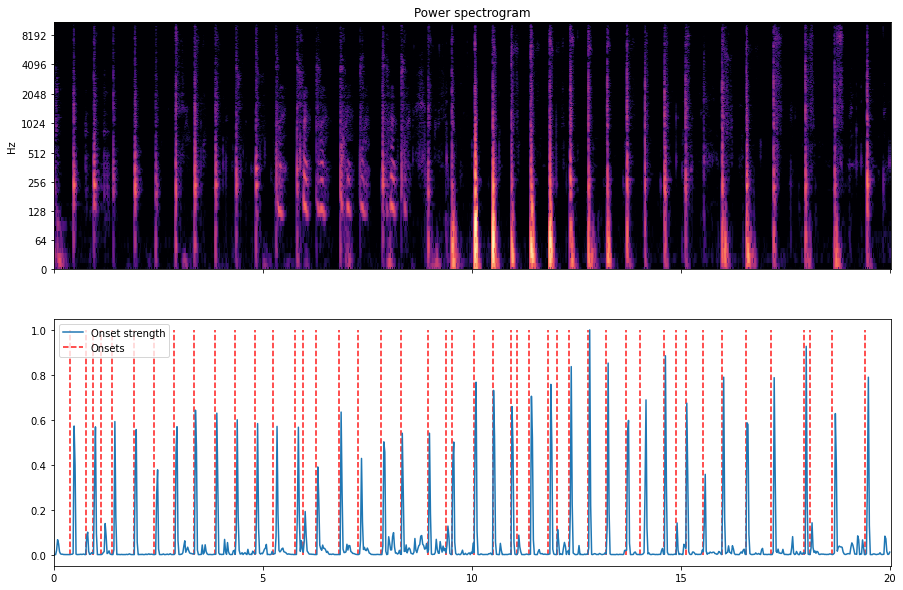

In [10]:
y = s[10 * settings.SAMPLE_RATE:30 * settings.SAMPLE_RATE]

sr = settings.SAMPLE_RATE

o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, backtrack=True, units="frames")

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 10))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()

In [11]:
# Understanding where the onsets are with a click track
clicks = librosa.clicks(frames=onset_frames, sr=settings.SAMPLE_RATE, length=len(y))

In [12]:
ipd.Audio(y + clicks, rate=settings.SAMPLE_RATE)

## With Peak Picking

From manually listening to the track, I know there should be 20 peaks picked.

In [13]:
onset_frames_pp = librosa.util.peak_pick(o_env, 10, 10, 10, 10, 0.25, 5)

In [14]:
# Then we backtrack to capture the whole sample
onset_frames_pp_bt = onset_backtrack(onset_frames_pp, o_env)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


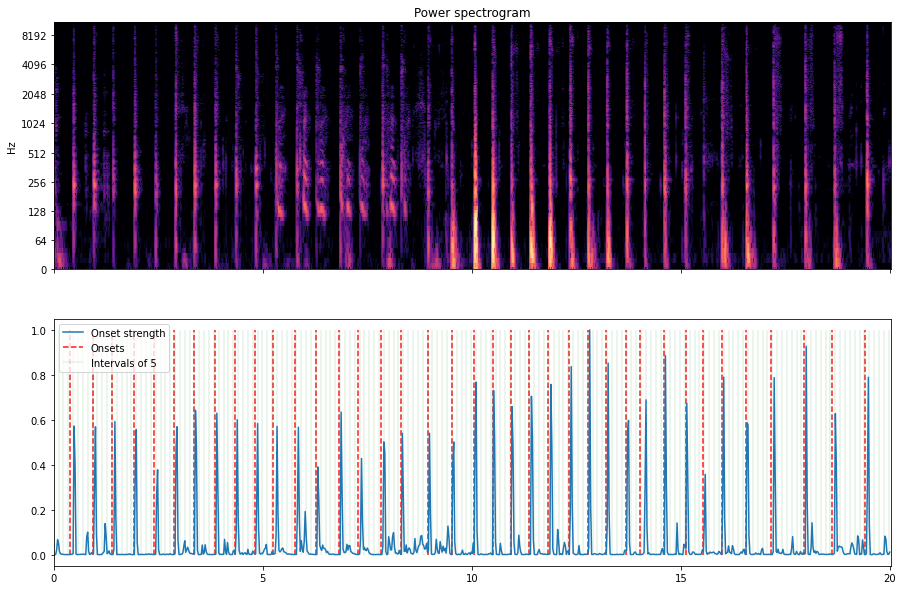

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 10))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames_pp_bt], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].vlines(times[[x for x in range(0, len(times), 5)]], 0, o_env.max(), color='g', alpha=0.1,
           linestyle='-', label='Intervals of 5')
ax[1].legend()

In [16]:
# Understanding where the onsets are with a click track
clicks = librosa.clicks(frames=onset_frames_pp_bt, sr=settings.SAMPLE_RATE, length=len(y))

In [17]:
ipd.Audio(y + clicks, rate=settings.SAMPLE_RATE)

# Slicing

Just a simple slice from onset to onset.

In [20]:
def get_onsets(sample: np.ndarray, sr: int = settings.SAMPLE_RATE) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    onset_envelope = librosa.onset.onset_strength(sample, sr=sr)
    times = librosa.times_like(onset_envelope, sr=sr)

    onsets = librosa.util.peak_pick(onset_envelope, 10, 10, 10, 10, 0.25, 5)
    onsets = onset_backtrack(onsets, onset_envelope)
    
    return onsets

In [21]:
s = read_sample("../data/recordings/kicks.wav")
o = get_onsets(s)

In [22]:
def get_slices(sample: np.ndarray, sr: int = settings.SAMPLE_RATE) -> np.ndarray:
    # Calculate the onsets
    onsets = get_onsets(sample, sr)
    
    # Convert onset times to samples
    onset_samples = librosa.frames_to_samples(onsets)
    
    # Slice sample into separate samples by onsets
    slices: List[np.ndarray] = []
    
    # The first sample starts at the first onset
    prev_slice_pt: int = onset_samples[0]
    for slice_pt in onset_samples[1:]:
        slice_ = sample[prev_slice_pt:slice_pt]
        slices.append(slice_)
        prev_slice_pt = slice_pt
        
    # The last slice goes to the end of the audio
    slices.append(sample[onset_samples[-1]:])
    
    return slices

In [25]:
s = read_sample("../data/recordings/kicks.wav")
slices = get_slices(s)

In [26]:
ipd.Audio(slices[24], rate=settings.SAMPLE_RATE)

`get_onsets` and `get_slices` have been moved to beat2d.split

In [28]:
s = read_sample("../data/recordings/kicks.wav")
oneshots = slicing.split_oneshots(s)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

for oneshot, ax in zip(oneshots[:len(axes.flatten())], axes.flatten()):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.plot(oneshot)